# Multi-Vehicle Detection and Tracking

For this project, the aim is to take input video frames and detect and track the vehicles in the frames. There are totally 80,000 representative frames across train and test sets as well as 14 different attributes to enhance our predictions. There are totally 50 sequences that have number of frames ranging from 83 to 2790. The videos are captured by an UAV platform at various urban locations such as squares, arterial streets, toll stations, highways, crossings and T-junctions. The videos sequences are recorded at 30 frames per seconds (fps) with the resolution of 1080x540 pixels.

# Sequence-Level Data Attributes and Data Splits

<img src="attrs.png">

<img src="data_types.png">

In [79]:
# Import necessary packages
import os
import pandas as pd
import numpy as np
import cv2
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
import matplotlib.pyplot as plt
from itertools import product

Using TensorFlow backend.


In [15]:
# Keep track of train and test sequences
attr_dir = 'm_attributes/M_attr'
train_seq = [x[1:5] for x in os.listdir(attr_dir+'/train')]
test_seq = [x[1:5] for x in os.listdir(attr_dir+'/test')]

# Sequence Level Features Analysis

In [16]:
# Analyze sequence level attributes in train and test data

def get_seq_attr(train_or_test, seq_dict):
    dir_req = attr_dir+'/'+train_or_test
    for i in os.listdir(dir_req):
        temp = open(dir_req+'/'+i).read().split(',')
        temp = [x[0] for x in temp]
        seq_dict['daylight'].append(temp[0])
        seq_dict['night'].append(temp[1])
        seq_dict['fog'].append(temp[2])
        seq_dict['low_alt'].append(temp[3])
        seq_dict['med_alt'].append(temp[4])
        seq_dict['high_alt'].append(temp[5])
        seq_dict['front_view'].append(temp[6])
        seq_dict['side_view'].append(temp[7])
        seq_dict['bird_view'].append(temp[8])
        seq_dict['long_term'].append(temp[9])
    return seq_dict

train_seq_dict = {'daylight':[],
                 'night':[],
                 'fog':[],
                 'low_alt':[],
                 'med_alt':[],
                 'high_alt':[],
                 'front_view':[],
                 'side_view':[],
                 'bird_view':[],
                 'long_term':[]}

test_seq_dict = {'daylight':[],
                 'night':[],
                 'fog':[],
                 'low_alt':[],
                 'med_alt':[],
                 'high_alt':[],
                 'front_view':[],
                 'side_view':[],
                 'bird_view':[],
                 'long_term':[]}

train_seq_dict = get_seq_attr('train',train_seq_dict)
test_seq_dict = get_seq_attr('test',test_seq_dict)

daylight


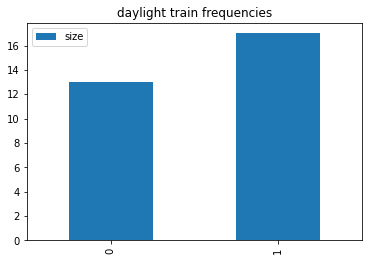

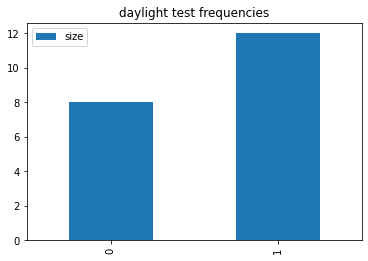



night


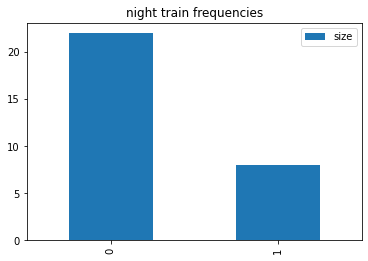

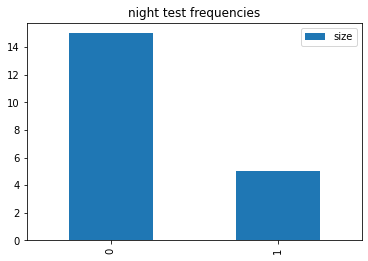



fog


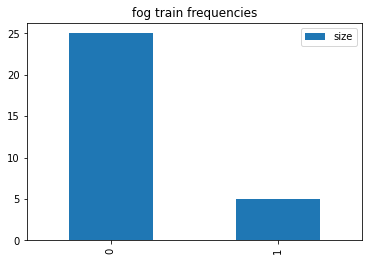

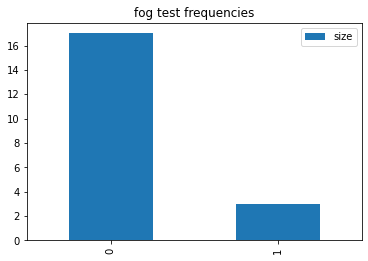



low_alt


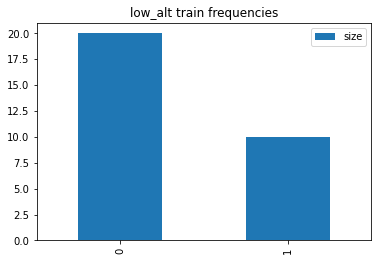

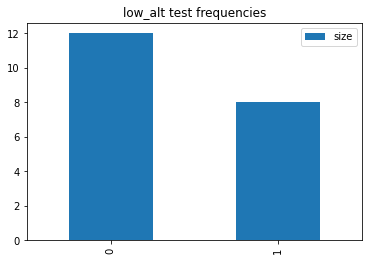



med_alt


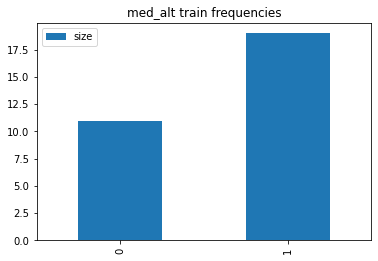

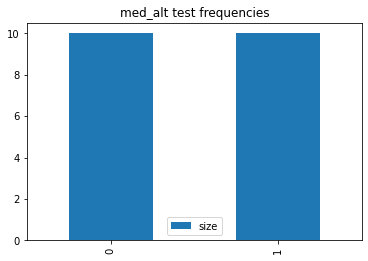



high_alt


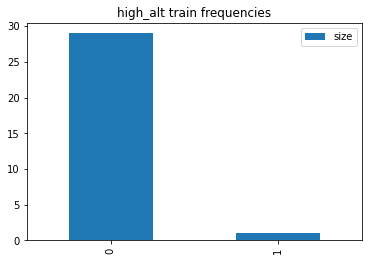

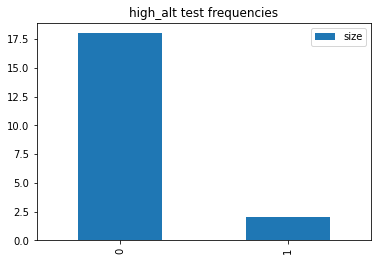



front_view


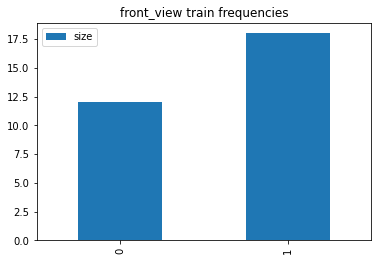

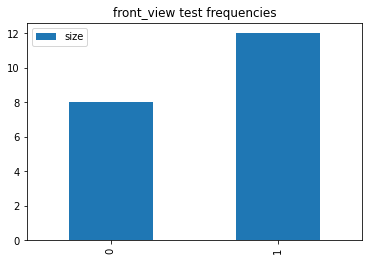



side_view


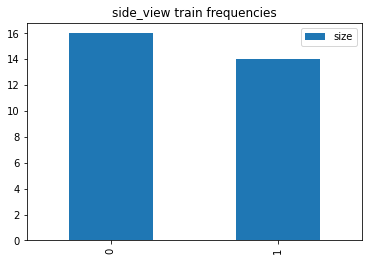

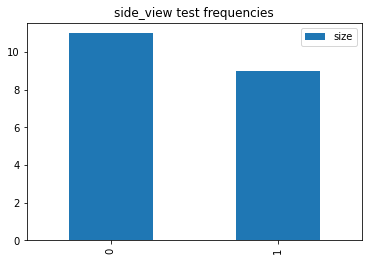



bird_view


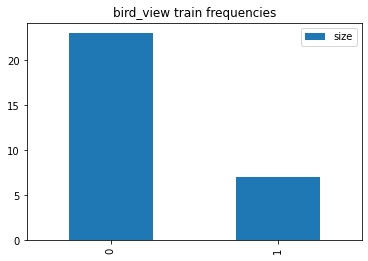

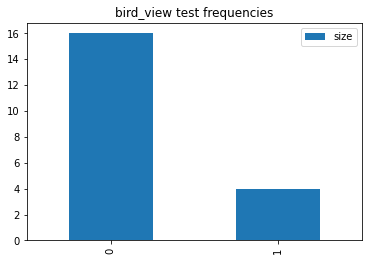



long_term


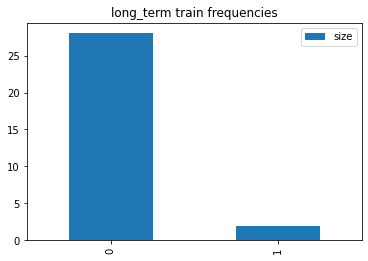

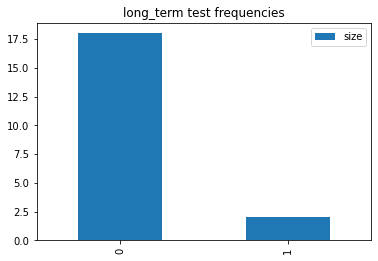

In [17]:
for feature in train_seq_dict:
    print(feature)
    train_list = train_seq_dict[feature]
    test_list = test_seq_dict[feature]
    df = pd.DataFrame({'freq': train_list})
    df.groupby('freq', as_index=False).size().plot(kind='bar')
    plt.title(feature + ' train frequencies')
    plt.show()
    df = pd.DataFrame({'freq': test_list})
    df.groupby('freq', as_index=False).size().plot(kind='bar')
    plt.title(feature + ' test frequencies')
    plt.show()
    print('\n')

# Vehicle Detection Features Analysis

In [18]:
# Create target dataframes for train and test sequences

train_targets = pd.DataFrame()
for t in train_seq:
    target_file = 'm_targets/m_targets/GT/M'+t+'_gt_whole.txt'
    df = pd.read_csv(target_file, header = None)
    df.columns = ['frame_index', 'target_id', 'bbox_left', 'bbox_top', 'bbox_width', 'bbox_height',
                 'out_of_view', 'occlusion', 'object_category']
    df['seq_label'] = t
    train_targets = train_targets.append(df)

test_targets = pd.DataFrame()
for t in test_seq:
    target_file = 'm_targets/m_targets/GT/M'+t+'_gt_whole.txt'
    df = pd.read_csv(target_file, header = None)
    df.columns = ['frame_index', 'target_id', 'bbox_left', 'bbox_top', 'bbox_width', 'bbox_height',
                 'out_of_view', 'occlusion', 'object_category']
    df['seq_label'] = t
    test_targets = test_targets.append(df)

In [20]:
print('Dimensions of train targets from 30 sequences: ',train_targets.shape)
print('Dimensions of test targets from 20 sequences: ',test_targets.shape)

Dimensions of train targets from 30 sequences:  (422911, 10)
Dimensions of test targets from 20 sequences:  (375884, 10)


In [21]:
# Check if any nulls in data
print(train_targets.isnull().sum().sum())
print(test_targets.isnull().sum().sum())

0
0


In [22]:
# See what the data looks like
train_targets.head()

,frame_index,target_id,bbox_left,bbox_top,bbox_width,bbox_height,out_of_view,occlusion,object_category,seq_label
0,1,1,141,147,106,45,1,1,3,0101
1,2,1,138,147,106,45,1,1,3,0101
2,3,1,136,148,106,45,1,1,3,0101
3,4,1,134,148,106,45,1,1,3,0101
4,5,1,131,149,106,45,1,1,3,0101


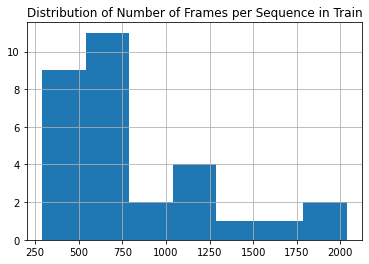

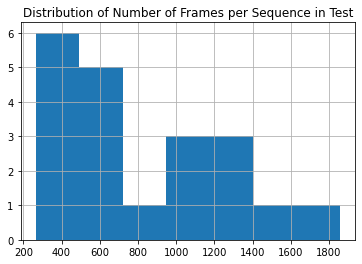

In [23]:
# Check size of sequences in train and test
train_targets.groupby('seq_label')['frame_index'].nunique().hist(bins = 7)
plt.title('Distribution of Number of Frames per Sequence in Train')
plt.show()

test_targets.groupby('seq_label')['frame_index'].nunique().hist(bins = 7)
plt.title('Distribution of Number of Frames per Sequence in Test')
plt.show()

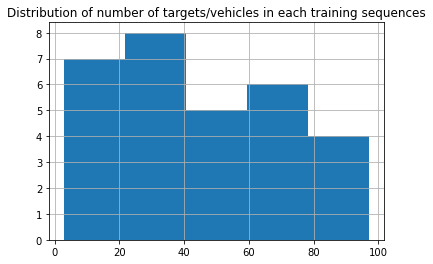

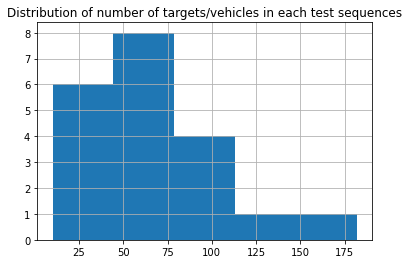

In [24]:
# Get distribution of number of targets per sequence
train_targets.groupby('seq_label')['target_id'].nunique().hist(bins = 5)
plt.title('Distribution of number of targets/vehicles in each training sequences')
plt.show()
print('\n')
test_targets.groupby('seq_label')['target_id'].nunique().hist(bins = 5)
plt.title('Distribution of number of targets/vehicles in each test sequences')
plt.show()

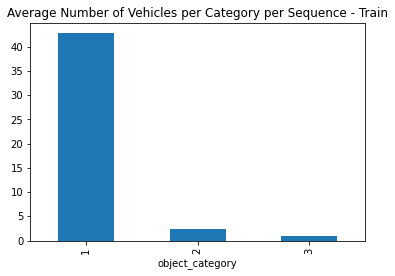

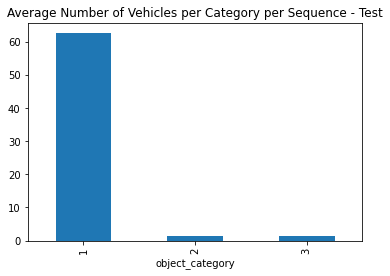

In [25]:
# Number of vehicles belonging to each category 
# 1 = car
# 2 = truck
# 3 = bus

temp = train_targets.groupby(['seq_label', 'object_category'])['target_id'].nunique().reset_index()
temp = pd.DataFrame(list(product(train_targets['seq_label'].unique(), 
                                 train_targets['object_category'].unique())), 
                    columns=['seq_label', 'object_category']).merge(temp, on = ['seq_label', 'object_category'], how = 'outer')
temp.fillna(0, inplace = True)
temp['object_category'] = temp.object_category.astype(str)
temp.groupby('object_category')['target_id'].mean().plot(kind = 'bar')
plt.title('Average Number of Vehicles per Category per Sequence - Train')
plt.show()

temp = test_targets.groupby(['seq_label', 'object_category'])['target_id'].nunique().reset_index()
temp = pd.DataFrame(list(product(test_targets['seq_label'].unique(), 
                                 test_targets['object_category'].unique())), 
                    columns=['seq_label', 'object_category']).merge(temp, on = ['seq_label', 'object_category'], how = 'outer')
temp.fillna(0, inplace = True)
temp['object_category'] = temp.object_category.astype(str)
temp.groupby('object_category')['target_id'].mean().plot(kind = 'bar')
plt.title('Average Number of Vehicles per Category per Sequence - Test')
plt.show()

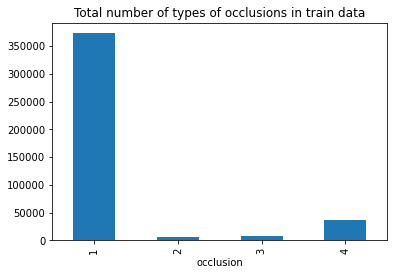

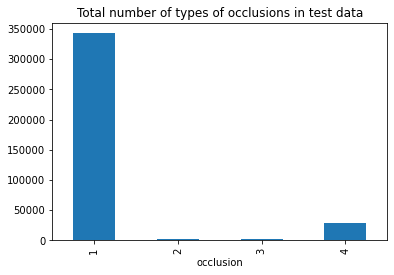

In [26]:
# Number of instances of different types of occlusions in data
# 'no-occ'=1, 'large-occ'=2, 'medium-occ'=3, 'small-occ'=4

train_targets.groupby('occlusion').size().plot(kind = 'bar')
plt.title('Total number of types of occlusions in train data')
plt.show()

test_targets.groupby('occlusion').size().plot(kind = 'bar')
plt.title('Total number of types of occlusions in test data')
plt.show()

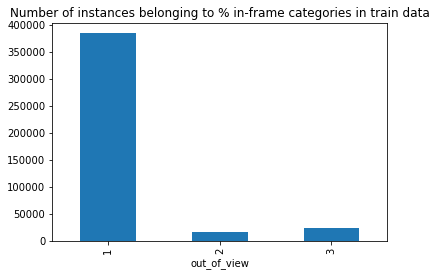

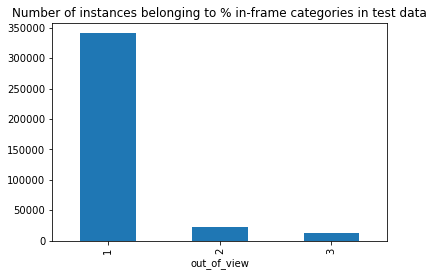

In [27]:
# Number of instances vehicles are in-frame, out-of-frame
# no-out (NO 0%) = 1, small-out (SO 1%~30%) = 3, medium-out (MO 30%~50%) = 2

train_targets.groupby('out_of_view').size().plot(kind = 'bar')
plt.title('Number of instances belonging to % in-frame categories in train data')
plt.show()

test_targets.groupby('out_of_view').size().plot(kind = 'bar')
plt.title('Number of instances belonging to % in-frame categories in test data')
plt.show()

# Object Detection using Mask R-CNN

<img src="arch.png">

In [73]:
# Get the masks for input image in a sequence (train and test)
def get_mask(sequence, image_index):
    
    # Load Image
    img_path = 'm_data/UAV-benchmark-M/M' + sequence + '/img' + '0'*(6-len(str(image_index))) + str(image_index) + '.jpg'
    img = cv2.imread(img_path)
    
    # Convert RGB to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Get annotations
    if sequence in train_seq:
        df = train_targets[(train_targets.seq_label == sequence) & 
                           (train_targets.frame_index == image_index)].reset_index(drop = True)
    else:
        df = test_targets[(test_targets.seq_label == sequence) & 
                          (test_targets.frame_index == image_index)].reset_index(drop = True)
    
    # Get dimensions of image and number of bounding boxes
    h = img.shape[0]
    w = img.shape[1]
    num_bb = df.shape[0]
    res = np.zeros((h, w), dtype=int)
    
    for i in range(num_bb):
        bb_left = df.bbox_left[i]
        bb_top = df.bbox_top[i]
        bb_width = df.bbox_width[i]
        bb_height = df.bbox_height[i]
        res[bb_top:bb_top + bb_height, bb_left:bb_left + bb_width] = 1
        
    return img, res

In [74]:
img, res = get_mask('0101',1)

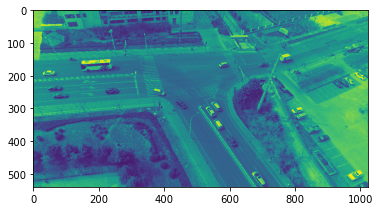

In [75]:
plt.imshow(img)

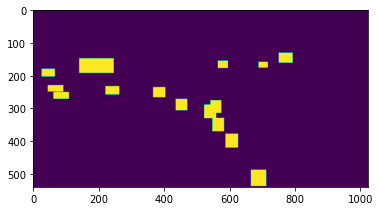

In [76]:
plt.imshow(res)

# Transfer Learning with Mask R-CNN Model built with MS COCO

In [80]:
# Define a configuration for the model
class VehicleDetection(Config):

    NAME = "vehicle_detection"
    # Number of classes (background + vehicle), change later to accomodate types of vehicles
    NUM_CLASSES = 2
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 131

# prepare config
config = VehicleDetection()

In [ ]:
# define the model
model = MaskRCNN(mode = 'training', model_dir = './', config = config)
# load weights (mscoco) and exclude the output layers
model.load_weights('mask_rcnn_coco.h5', by_name = True, exclude = ["mrcnn_class_logits", 
                                                                   "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers only) - change train and test set
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')